# Step 1: Imports and Google Drive Setup

In [ ]:
import pandas as pd
import numpy as np
import random
import time
import matplotlib.pyplot as plt
import seaborn as sns
import concurrent.futures
import psutil
from google.colab import drive

drive.mount('/content/drive')

import os
os.chdir('/content/drive/MyDrive/mlpc_datasets')

!ls


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
node_info.csv  smartgrid_dataset_5000.csv  source_info.csv


# Step 2: Load Datasets and Preprocess for 24-Hour Cycle

In [ ]:
df = pd.read_csv("smartgrid_dataset_5000.csv")
df_nodes = pd.read_csv("node_info.csv")
df_sources = pd.read_csv("source_info.csv")

nodes = df_nodes['Node_ID'].tolist()[:10]
sources = df_sources['Source_ID'].tolist()[:3]
CHROMO_LEN = len(nodes) * len(sources)

hours = range(24)
demand_map = {hour: df[df['Timestamp'] == hour].groupby('Node_ID')['Demand_kWh'].mean().to_dict() for hour in hours}
cost_map = {hour: df[df['Timestamp'] == hour].groupby('Source_ID')['Cost_per_kWh'].mean().to_dict() for hour in hours}
loss_map = {hour: df[df['Timestamp'] == hour].groupby('Source_ID')['Line_Loss_%'].mean().to_dict() for hour in hours}
source_max = df_sources.set_index('Source_ID')['Max_Hourly_Capacity_kWh'].to_dict()

# Step 3: Chromosome Encoding and Fitness Function

In [ ]:
def generate_chromosome():
    return [random.uniform(0, 100) for _ in range(CHROMO_LEN)]

def improved_fitness(chromo, hour):
    allocation = np.array(chromo).reshape(len(nodes), len(sources))
    total_cost, total_loss, penalty = 0, 0, 0
    source_alloc = dict.fromkeys(sources, 0)
    node_alloc = dict.fromkeys(nodes, 0)

    max_cost = max(cost_map[hour].values()) * sum(demand_map[hour].values())
    max_loss = sum(demand_map[hour].values()) * 0.1

    for i, node in enumerate(nodes):
        for j, source in enumerate(sources):
            e = max(0, allocation[i][j])
            source_alloc[source] += e
            node_alloc[node] += e
            total_cost += e * cost_map[hour][source] / max_cost
            total_loss += e * (loss_map[hour][source] / 100) / max_loss

    for src in sources:
        if source_alloc[src] > source_max[src]:
            penalty += (source_alloc[src] - source_max[src]) * 10000
    for node in nodes:
        penalty += abs(node_alloc[node] - demand_map[hour][node]) * 1000

    return -(total_cost + total_loss + penalty)

# Step 4: GA Helper Functions

In [ ]:
def roulette_selection(pop, scores):
    total = sum(scores)
    if total <= 0: return random.choice(pop)
    pick, current = random.uniform(0, total), 0
    for ind, score in zip(pop, scores):
        current += score
        if current >= pick: return ind
    return pop[-1]

def crossover(p1, p2, rate=0.8):
    if random.random() > rate: return p1.copy()
    point = random.randint(1, CHROMO_LEN - 1)
    return p1[:point] + p2[point:]

def mutate(chromo, rate=0.1):
    return [max(0, gene + random.uniform(-10, 10)) if random.random() < rate else gene for gene in chromo]

# Step 5: Serial GA Implementation

In [ ]:
def run_serial_ga(hour, pop_size=150, gens=150, elitism=5):
    population = [generate_chromosome() for _ in range(pop_size)]
    best_score = float('-inf')
    history, best_chromo = [], None

    for gen in range(gens):
        scores = [improved_fitness(ind, hour) for ind in population]
        sorted_pop = [x for _, x in sorted(zip(scores, population), key=lambda x: x[0], reverse=True)]

        if max(scores) > best_score:
            best_score = max(scores)
            best_chromo = population[scores.index(max(scores))]

        history.append(max(scores))
        next_gen = sorted_pop[:elitism]

        while len(next_gen) < pop_size:
            p1 = roulette_selection(population, [s + abs(min(scores)) + 1 for s in scores])
            p2 = roulette_selection(population, [s + abs(min(scores)) + 1 for s in scores])
            child = crossover(p1, p2)
            child = mutate(child, 0.1 - 0.05 * (gen / gens))
            next_gen.append(child)

        population = next_gen

    return history, best_chromo


# Step 6: Parallel GA Implementation

In [ ]:
def fitness_parallel(population_chunk, hour):
    return [improved_fitness(ind, hour) for ind in population_chunk]

def run_parallel_ga(hour, pop_size=150, gens=150, elitism=5):
    population = [generate_chromosome() for _ in range(pop_size)]
    best_score = float('-inf')
    history, best_chromo = [], None
    cpu_usage = []

    with concurrent.futures.ThreadPoolExecutor() as executor:
        for gen in range(gens):
            start_time = time.time()
            chunk_size = max(10, pop_size // os.cpu_count())
            chunks = [population[i:i + chunk_size] for i in range(0, len(population), chunk_size)]
            futures = [executor.submit(fitness_parallel, chunk, hour) for chunk in chunks]
            scores_list = [f.result() for f in futures]
            scores = [s for sublist in scores_list for s in sublist]
            cpu_usage.append(psutil.cpu_percent(interval=None))

            sorted_pop = [x for _, x in sorted(zip(scores, population), key=lambda x: x[0], reverse=True)]

            if max(scores) > best_score:
                best_score = max(scores)
                best_chromo = population[scores.index(max(scores))]

            history.append(max(scores))
            next_gen = sorted_pop[:elitism]

            while len(next_gen) < pop_size:
                p1 = roulette_selection(population, [s + abs(min(scores)) + 1 for s in scores])
                p2 = roulette_selection(population, [s + abs(min(scores)) + 1 for s in scores])
                child = crossover(p1, p2)
                child = mutate(child, 0.1 - 0.05 * (gen / gens))
                next_gen.append(child)

            population = next_gen

    return history, best_chromo, cpu_usage

# Step 7: Greedy Baseline

In [ ]:
def run_greedy(hour):
    total_cost, total_loss = 0, 0
    allocation = {node: {} for node in nodes}
    local_source_max = source_max.copy()

    for node in nodes:
        demand = demand_map[hour][node]
        sorted_sources = sorted(sources, key=lambda s: cost_map[hour][s])
        for source in sorted_sources:
            if demand <= 0: break
            available = local_source_max[source]
            used = min(demand, available)
            total_cost += used * cost_map[hour][source]
            total_loss += used * (loss_map[hour][source] / 100)
            local_source_max[source] -= used
            demand -= used
            allocation[node][source] = used

    return total_cost, total_loss, allocation

# Step 8: Parameter Sensitivity Analysis

In [ ]:
def parameter_sensitivity_analysis():
    pop_sizes = [50, 100, 150]
    mutation_rates = [0.05, 0.1, 0.15]
    crossover_rates = [0.6, 0.8, 0.9]
    results = []

    for pop_size in pop_sizes:
        for mutation_rate in mutation_rates:
            for crossover_rate in crossover_rates:
                start_time = time.time()
                history, _ = run_serial_ga(hour=12, pop_size=pop_size, gens=150)
                end_time = time.time()
                results.append({
                    'pop_size': pop_size,
                    'mutation_rate': mutation_rate,
                    'crossover_rate': crossover_rate,
                    'best_fitness': max(history),
                    'time': end_time - start_time
                })

    return pd.DataFrame(results)

# Step 9: Main Execution and Visualization

In [ ]:
def get_cost_loss(chromo, hour):
    allocation = np.array(chromo).reshape(len(nodes), len(sources))
    total_cost, total_loss = 0, 0
    for i, node in enumerate(nodes):
        for j, source in enumerate(sources):
            energy = max(0, allocation[i][j])
            total_cost += energy * cost_map[hour][source]
            total_loss += energy * (loss_map[hour][source] / 100)
    return round(total_cost, 2), round(total_loss, 2)


In [ ]:
 #Initialize Metrics for Evaluation
serial_times, parallel_times, greedy_times = [], [], []
serial_costs, parallel_costs, greedy_costs = [], [], []
serial_losses, parallel_losses, greedy_losses = [], [], []
serial_histories, parallel_histories = [], []
cpu_usages = []



In [ ]:
for hour in hours:
    # Serial GA
    start_serial = time.time()
    history_serial, best_serial = run_serial_ga(hour)
    end_serial = time.time()
    serial_time = end_serial - start_serial
    cost_serial, loss_serial = get_cost_loss(best_serial, hour)

    # Parallel GA
    start_parallel = time.time()
    history_parallel, best_parallel, cpu_usage = run_parallel_ga(hour)
    end_parallel = time.time()
    parallel_time = end_parallel - start_parallel
    cost_parallel, loss_parallel = get_cost_loss(best_parallel, hour)

    # Greedy
    start_greedy = time.time()
    cost_greedy, loss_greedy, _ = run_greedy(hour)
    end_greedy = time.time()
    greedy_time = end_greedy - start_greedy

    # Store metrics
    serial_times.append(serial_time)
    parallel_times.append(parallel_time)
    greedy_times.append(greedy_time)

    serial_costs.append(cost_serial)
    parallel_costs.append(cost_parallel)
    greedy_costs.append(cost_greedy)

    serial_losses.append(loss_serial)
    parallel_losses.append(loss_parallel)
    greedy_losses.append(loss_greedy)

    serial_histories.append(history_serial)
    parallel_histories.append(history_parallel)

    cpu_usages.append(np.mean(cpu_usage))


#Plot – Convergence Curve of GAs

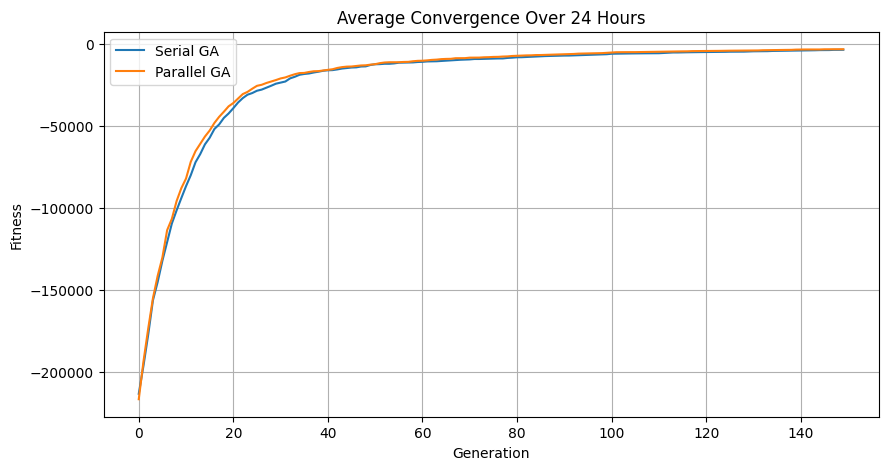

In [ ]:
plt.figure(figsize=(10, 5))
plt.plot(np.mean(serial_histories, axis=0), label='Serial GA')
plt.plot(np.mean(parallel_histories, axis=0), label='Parallel GA')
plt.title("Average Convergence Over 24 Hours")
plt.xlabel("Generation")
plt.ylabel("Fitness")
plt.legend()
plt.grid(True)
plt.show()


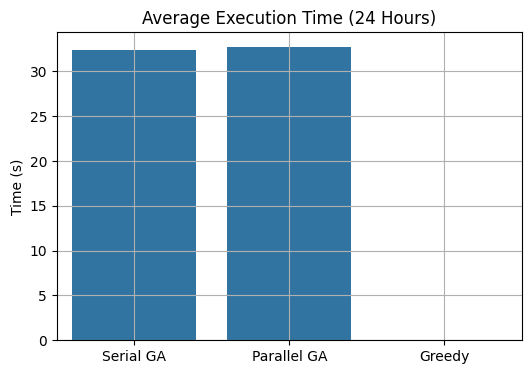

In [ ]:
#Plot – Average Execution Time
methods = ['Serial GA', 'Parallel GA', 'Greedy']
avg_times = [np.mean(serial_times), np.mean(parallel_times), np.mean(greedy_times)]

plt.figure(figsize=(6, 4))
sns.barplot(x=methods, y=avg_times)
plt.title("Average Execution Time (24 Hours)")
plt.ylabel("Time (s)")
plt.grid(True)
plt.show()



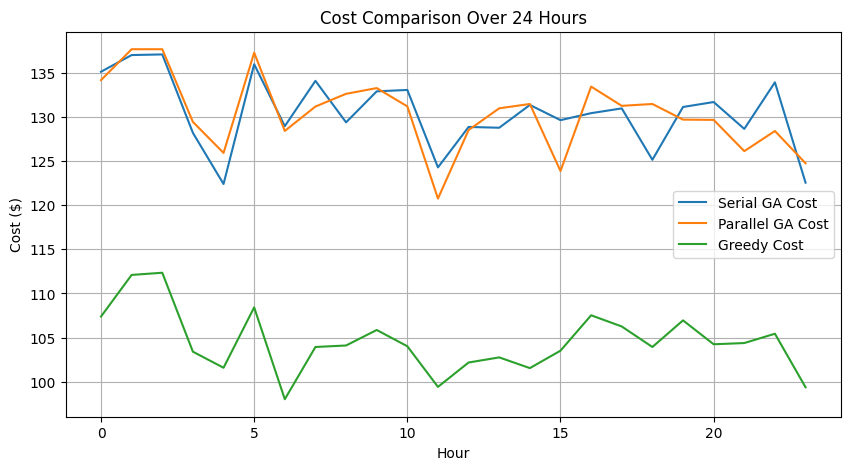

In [ ]:
#Plot – Cost Comparison
plt.figure(figsize=(10, 5))
plt.plot(serial_costs, label='Serial GA Cost')
plt.plot(parallel_costs, label='Parallel GA Cost')
plt.plot(greedy_costs, label='Greedy Cost')
plt.title("Cost Comparison Over 24 Hours")
plt.xlabel("Hour")
plt.ylabel("Cost ($)")
plt.legend()
plt.grid(True)
plt.show()


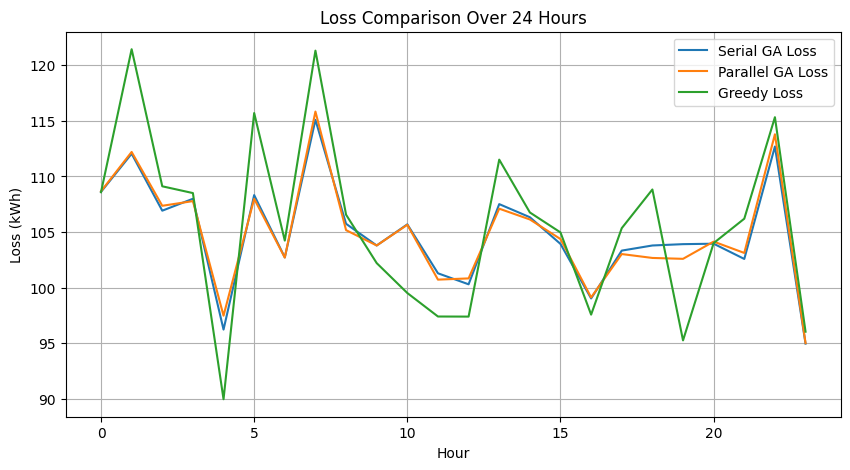

In [ ]:
#Plot – Loss Comparison
plt.figure(figsize=(10, 5))
plt.plot(serial_losses, label='Serial GA Loss')
plt.plot(parallel_losses, label='Parallel GA Loss')
plt.plot(greedy_losses, label='Greedy Loss')
plt.title("Loss Comparison Over 24 Hours")
plt.xlabel("Hour")
plt.ylabel("Loss (kWh)")
plt.legend()
plt.grid(True)
plt.show()


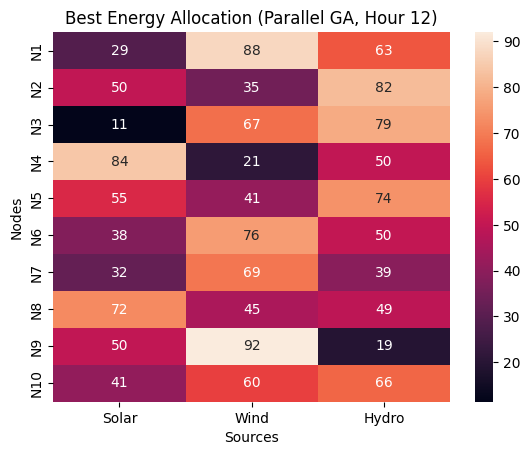

In [ ]:
#Heatmap – Best Allocation (Hour 12, Parallel GA)
alloc_array = np.array(best_parallel).reshape(len(nodes), len(sources))
sns.heatmap(alloc_array, xticklabels=sources, yticklabels=nodes, annot=True, fmt=".0f")
plt.title("Best Energy Allocation (Parallel GA, Hour 12)")
plt.xlabel("Sources")
plt.ylabel("Nodes")
plt.show()



In [ ]:
#Sensitivity Analysis
sensitivity_df = parameter_sensitivity_analysis()
print("Parameter Sensitivity Analysis:")
print(sensitivity_df)


Parameter Sensitivity Analysis:
    pop_size  mutation_rate  crossover_rate  best_fitness       time
0         50           0.05             0.6  -2660.943171   1.995851
1         50           0.05             0.8  -2452.553163   1.586718
2         50           0.05             0.9  -2025.594771   1.587999
3         50           0.10             0.6  -3436.536591   2.581407
4         50           0.10             0.8  -3489.057575   2.483505
5         50           0.10             0.9  -3425.512401   2.290234
6         50           0.15             0.6  -3866.281257   1.572772
7         50           0.15             0.8  -2510.959671   1.598370
8         50           0.15             0.9  -3496.143185   1.563824
9        100           0.05             0.6  -4475.003205  11.084196
10       100           0.05             0.8  -3513.030656  10.986146
11       100           0.05             0.9  -2691.789438  10.130435
12       100           0.10             0.6  -3904.721927  10.066854
13

In [ ]:
#Summary Statistics
print(f"Average Serial GA Time: {np.mean(serial_times):.2f}s")
print(f"Average Parallel GA Time: {np.mean(parallel_times):.2f}s")
print(f"Average Greedy Time: {np.mean(greedy_times):.2f}s")
print(f"Average Serial GA Cost: {np.mean(serial_costs):.2f}, Loss: {np.mean(serial_losses):.2f}")
print(f"Average Parallel GA Cost: {np.mean(parallel_costs):.2f}, Loss: {np.mean(parallel_losses):.2f}")
print(f"Average Greedy Cost: {np.mean(greedy_costs):.2f}, Loss: {np.mean(greedy_losses):.2f}")
print(f"Average CPU Usage (Parallel GA): {np.mean(cpu_usages):.2f}%")



Average Serial GA Time: 7.12s
Average Parallel GA Time: 7.48s
Average Greedy Time: 0.00s
Average Serial GA Cost: 130.68, Loss: 105.01
Average Parallel GA Cost: 130.37, Loss: 104.93
Average Greedy Cost: 104.53, Loss: 105.57


# Step 10: CPU Usage Monitoring

In [ ]:
def monitor_cpu_usage():
    return psutil.cpu_percent(interval=1, percpu=True)

print("CPU Usage During Execution:", monitor_cpu_usage())

CPU Usage During Execution: [65.7, 49.5]
